# Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 변수 정의해놓기

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# -------------------------------------------------------------------- 

# 하이퍼 파라미터
BATCH_SIZE = 16
EPOCHS = 10

print('Hyperparmeter')
print(f"BATCH_SIZE : {BATCH_SIZE}, EPOCHS : {EPOCHS}")

Hyperparmeter
BATCH_SIZE : 16, EPOCHS : 10


# Step 2. 데이터 준비하기

In [3]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train 데이터와 validation 데이터를 모두 filenames에 담기 (val이 적어서 직접 분리하기 위해서)
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train ', len(train_filenames))
print('val ',len(val_filenames))
print('test ',len(test_filenames))

train  4185
val  1047
test  624


In [4]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


In [5]:
# tf.data 인스턴스 생성 -> mini-batch로 작업

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print(f"Testing images count: {TEST_IMAGE_COUNT}")

Training images count: 4185
Validating images count: 1047
Testing images count: 624


In [25]:
# label 구분 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    
    return img, label

# AUTOTUME : 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
train_ds_mapped = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_mapped = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [38]:
# 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않다.
# 증가시켜볼 수 있는 방안 고민해보기
# -> augmentation (신중하게)
# 좌우 반전

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000, shuffle=True, aug=False):
    
    if aug:
        # augment 적용 부분이 배치처리 함수에 추가되었습니다.
        ds = ds.map(
                augment,       # augment 함수 적용
                num_parallel_calls=2
            )
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼 유지, 무작위로 선택
        
    ds = ds.repeat() # 여러번 데이터셋을 사용할 수 있게 해줌
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE만큼 batch 가져옴
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어어옴
    # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.

    return ds

train_ds = prepare_for_training(train_ds_mapped)
val_ds = prepare_for_training(val_ds_mapped)

In [85]:
image_batch, label_batch = next(iter(train_ds))
image_batch.shape, label_batch.shape

(TensorShape([16, 180, 180, 3]), TensorShape([16]))

In [86]:
image_batch, label_batch = next(iter(val_ds))
image_batch.shape, label_batch.shape

(TensorShape([16, 180, 180, 3]), TensorShape([16]))

# Step 3. 데이터 시각화

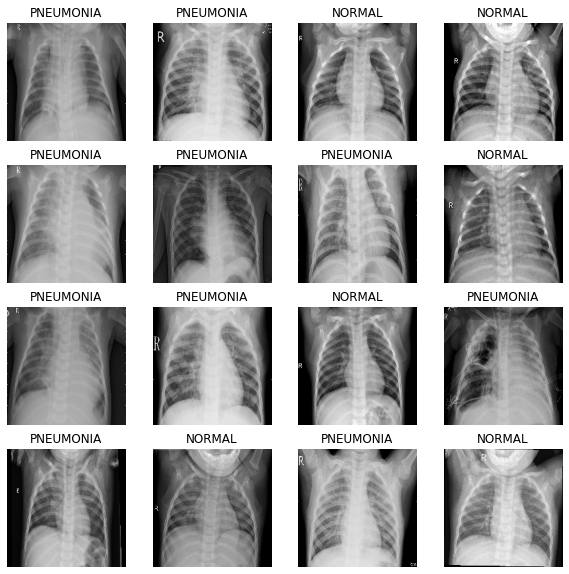

In [36]:
tmp_tr_ds = prepare_for_training(train_ds_mapped, shuffle=False, aug=False)


# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(tmp_tr_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

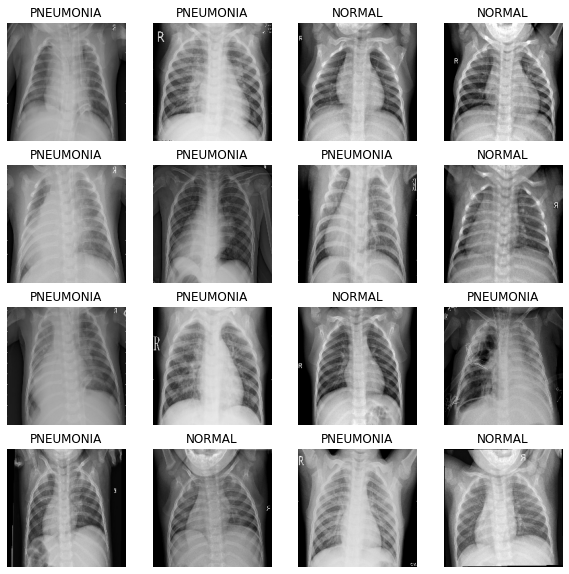

In [37]:
# augmentation한 결과
tmp_tr_ds = prepare_for_training(train_ds_mapped, shuffle=False, aug=True)

image_batch, label_batch = next(iter(tmp_tr_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. 모델링

## 기본 CNN 모델

In [41]:
def conv_block(filters, block_name):
    
    block = tf.keras.Sequential(name=block_name)  
    
    block.add(tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'))
    block.add(tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
    
    return block
    
def dense_block(units, dropout_rate, block_name):
    
    block = tf.keras.Sequential(name=block_name)  

    block.add(tf.keras.layers.Dense(units, activation='relu'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout_rate))
    
    # BatchNormalization과 Dropout을 같이 써도 될까?
    
    return block

def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32, 'conv_block1'),
        conv_block(64, 'conv_block2'),
        
        conv_block(128, 'conv_block3'),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256, 'conv_block4'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 'dense_block1'),
        dense_block(128, 0.5, 'dense_block2'),
        dense_block(64, 0.3, 'dense_block3'),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## RestNet-18 구현하기

참고 url  
https://github.com/keras-team/keras/blob/v2.14.0/keras/applications/resnet.py#L499-L533

In [127]:
def resdiual_block(x, filters, name):
    # shortcut filter개수 맞춰주기
    shortcut = tf.keras.layers.Conv2D(filters, 1, activation=None, padding='same', name=f"{name}_shortcut_conv")(x)
    
    x = tf.keras.layers.Conv2D(filters, 3, activation=None, padding='same', name=f"{name}_1_conv")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_1_bn")(x)
    x = tf.keras.layers.Activation("relu", name=f"{name}_1_relu")(x)
    
    x = tf.keras.layers.Conv2D(filters, 3, activation=None, padding='same', name=f"{name}_2_conv")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_2_bn")(x)
    x = tf.keras.layers.Add(name=f"{name}_2_add")([shortcut, x])
    
    x = tf.keras.layers.Activation("relu", name=f"{name}_out")(x)
    
    return x

def dense_block(x, units, dropout_rate, name):
    x = tf.keras.layers.Dense(units, activation='relu', name=f"{name}_dense")(x)
    x = tf.keras.layers.BatchNormalization(name=f"{name}_bn")(x)
    x = tf.keras.layers.Dropout(dropout_rate, name=f"{name}_dropout")(x)
    
    return x

In [128]:
def ResNet_18(filters, input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(input_shape)
    
    # conv1
    x = tf.keras.layers.Conv2D(64, 7, activation='relu', strides=2, padding='same', name='conv1_layer')(inputs)
    
    # Conv2 ~ Conv5    
    for i, f in enumerate(filters):
        # Conv2에서만 max pooling 진행
        if i == 0:
            x = tf.keras.layers.MaxPool2D(3, strides=2, padding='same', name=f'conv{i+2}_layer_mp')(x)
        
        x = resdiual_block(x, f, f'conv{i+2}_layer')
        
    # average pool
    x = tf.keras.layers.AveragePooling2D(7, name='ap')(x)
    
    # fully connected
    x = tf.keras.layers.Flatten()(x)

    x = dense_block(x, 512, 0.7, 'dense_block1')
    x = dense_block(x, 128, 0.5, 'dense_block2')
    x = dense_block(x, 64, 0.3, 'dense_block3')
    
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [129]:
filters = [64, 128, 256, 512]

resnet_18 = ResNet_18(filters)

In [130]:
resnet_18.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_layer (Conv2D)            (None, 90, 90, 64)   9472        input_21[0][0]                   
__________________________________________________________________________________________________
conv2_layer_mp (MaxPooling2D)   (None, 45, 45, 64)   0           conv1_layer[0][0]                
__________________________________________________________________________________________________
conv2_layer_1_conv (Conv2D)     (None, 45, 45, 64)   36928       conv2_layer_mp[0][0]             
____________________________________________________________________________________________

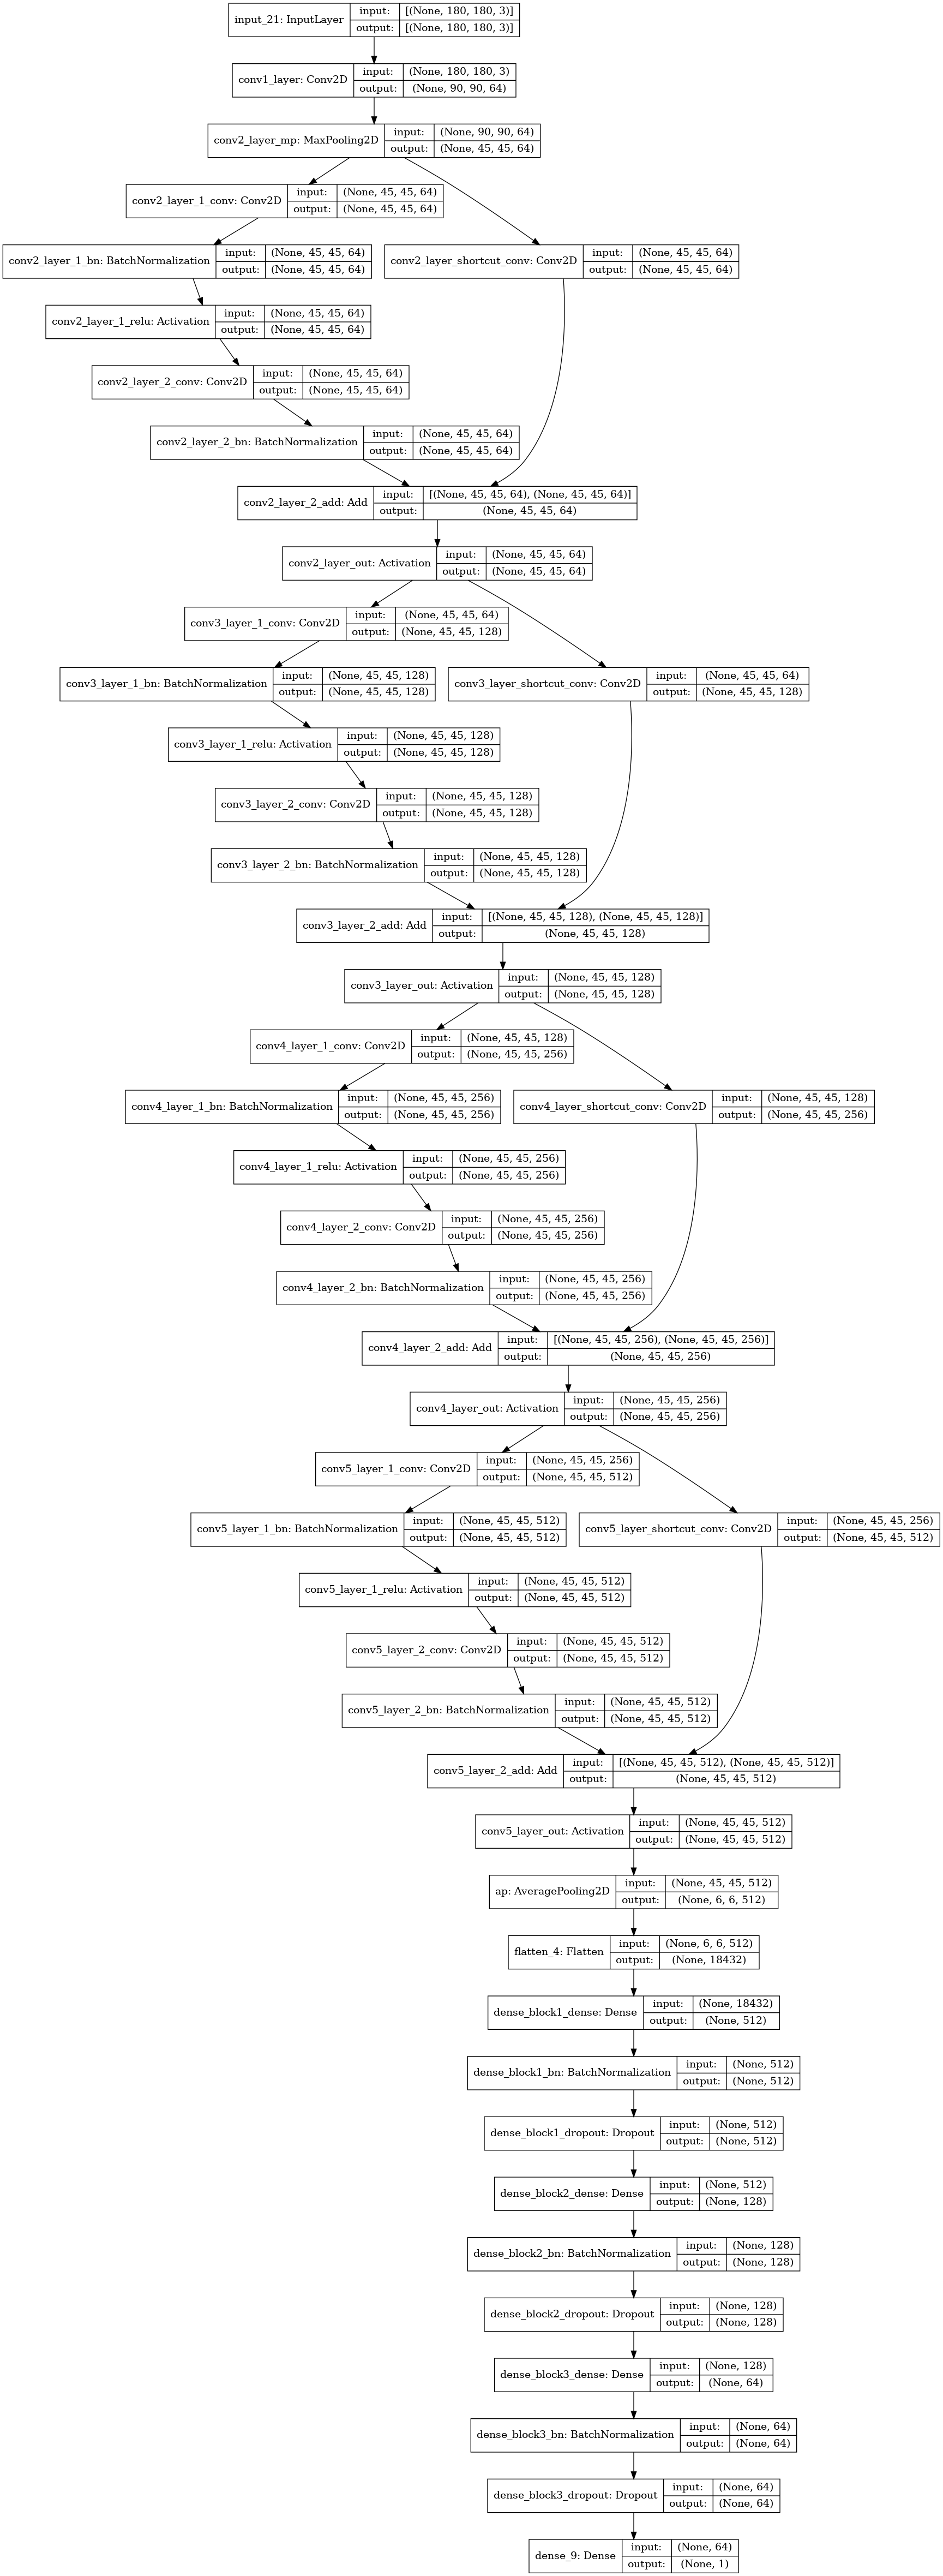

In [132]:
tf.keras.utils.plot_model(resnet_18, show_shapes=True)

# Step 5. 데이터 imbalance 처리

In [39]:
# Weight balancing 테크닉 사용

# 데이터셋이 많으면 더 적게 반영하도록 (데이터셋이 많은 쪽으로 모델이 학습하려 하니까)
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0  # Normal이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0 # Pneumonia 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

## basic cnn + aug (flip left and right)

In [44]:
# callback 함수 정의
from keras.callbacks import ModelCheckpoint

save_path = './model/cnn_aug_{epoch:02d}-{val_loss:.2f}.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [45]:
# build cnn model

with tf.device('/GPU:0'): # GPU 선택
    model = build_cnn_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [65]:
# cnn model + aug(filp left right)
train_ds = prepare_for_training(train_ds_mapped, shuffle=True, aug=True)
val_ds = prepare_for_training(val_ds_mapped, shuffle=True, aug=True)

EPOCHS = 50

with tf.device('/GPU:0'):
    cnn_history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[model_checkpoint_callback]
    )

Epoch 1/50
261/261 [==============================] - 62s 206ms/step - loss: 0.1627 - accuracy: 0.9373 - precision: 0.9817 - recall: 0.9331 - val_loss: 1.7853 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 53s 204ms/step - loss: 0.1369 - accuracy: 0.9440 - precision: 0.9871 - recall: 0.9369 - val_loss: 0.1409 - val_accuracy: 0.9452 - val_precision: 0.9682 - val_recall: 0.9568
Epoch 3/50
261/261 [==============================] - 52s 199ms/step - loss: 0.1394 - accuracy: 0.9473 - precision: 0.9859 - recall: 0.9427 - val_loss: 0.1059 - val_accuracy: 0.9587 - val_precision: 0.9724 - val_recall: 0.9712
Epoch 4/50
261/261 [==============================] - 52s 200ms/step - loss: 0.1506 - accuracy: 0.9444 - precision: 0.9819 - recall: 0.9427 - val_loss: 0.1692 - val_accuracy: 0.9279 - val_precision: 1.0000 - val_recall: 0.9018
Epoch 5/50
261/261 [==============================] - 52s 201ms/step - loss: 0.1457 - accura

Epoch 37/50
261/261 [==============================] - 47s 182ms/step - loss: 0.0525 - accuracy: 0.9813 - precision: 0.9964 - recall: 0.9785 - val_loss: 0.1358 - val_accuracy: 0.9529 - val_precision: 0.9864 - val_recall: 0.9490
Epoch 38/50
261/261 [==============================] - 47s 181ms/step - loss: 0.0571 - accuracy: 0.9784 - precision: 0.9954 - recall: 0.9755 - val_loss: 0.0976 - val_accuracy: 0.9663 - val_precision: 0.9789 - val_recall: 0.9751
Epoch 39/50
261/261 [==============================] - 48s 183ms/step - loss: 0.0611 - accuracy: 0.9787 - precision: 0.9954 - recall: 0.9759 - val_loss: 0.0801 - val_accuracy: 0.9702 - val_precision: 0.9729 - val_recall: 0.9869
Epoch 40/50
261/261 [==============================] - 47s 181ms/step - loss: 0.0538 - accuracy: 0.9811 - precision: 0.9958 - recall: 0.9788 - val_loss: 0.0573 - val_accuracy: 0.9769 - val_precision: 0.9793 - val_recall: 0.9895
Epoch 41/50
261/261 [==============================] - 48s 184ms/step - loss: 0.0570 - a

In [73]:
import os

os.listdir('./model')

['cnn_aug_40-0.06.h5',
 '.ipynb_checkpoints',
 'cnn_history.p',
 'cnn_aug_12-0.08.h5',
 'cnn_aug_41-0.06.h5',
 'basic_model.h5',
 'cnn_aug_35-0.07.h5',
 'cnn_aug_24-0.07.h5',
 'model.png']

In [68]:
import pickle

# 학습 기록 저장하기 , 실수로 다시 덮어써버리면 대참사니까 저장하고 주석처리 하자, 제발
# with open('model/cnn_history.p', 'wb') as f:
#     pickle.dump(cnn_history.history, f)

# with open("model/cnn_history.p", 'rb') as f:
#     data = pickle.load(f)

In [ ]:
# 모델 저장하기
# model.save('basic_model.h5')

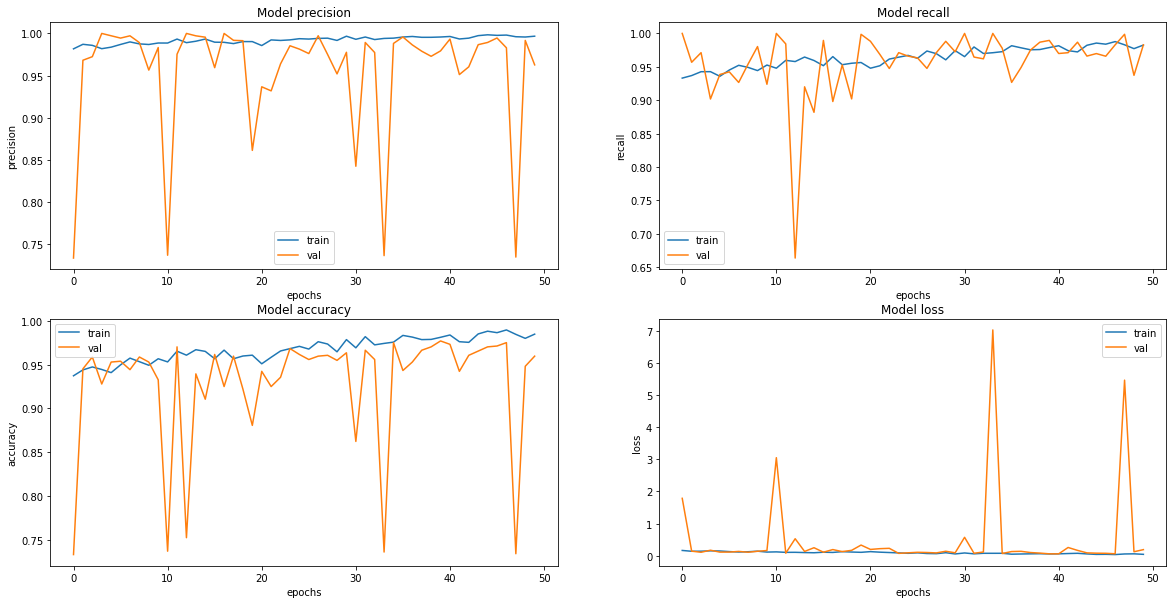

In [69]:
# 결과 확인하기
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(cnn_history.history[met])
    ax[i].plot(cnn_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [153]:
def plot_history(history):
    # 결과 확인하기
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

val 평가지표가 epoch마다 계속 튄다 -> 왜 그럴까?   
4000개밖에 안되는 학습 셋 때문이 아닐까? 과적합이 의심됨 -> epoch 12 vs epoch 40 비교해보자   


In [71]:
def test_model(model):
    loss, accuracy, precision, recall = model.evaluate(test_ds, verbose=0)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [75]:
epoch_12_cnn = tf.keras.models.load_model('./model/cnn_aug_12-0.08.h5')
test_model(epoch_12_cnn)

Loss: 1.056041955947876,
Accuracy: 0.7387820482254028,
Precision: 0.7059891223907471,
Recall: 0.9974358677864075


In [76]:
epoch_40_cnn = tf.keras.models.load_model('./model/cnn_aug_40-0.06.h5')
test_model(epoch_40_cnn)

Loss: 1.9128118753433228,
Accuracy: 0.7275640964508057,
Precision: 0.6971325874328613,
Recall: 0.9974358677864075


평가가 오히려 나빠짐   
그래프를 봐도 epoch이 증가한다고 수렴하지 않는 모습을 보임, 오히려 튐   
ResNet filter 테스트는 epoch을 5회정도로만 가져가면서 테스트해보자

In [156]:
# Augmentation 여부로 성능비교

# study 노드에서 학습해놨던 모델 vs 지금 학습시킨 모델
basic_cnn = tf.keras.models.load_model('./model/basic_model.h5')
test_model(basic_cnn)

Loss: 0.44658640027046204,
Accuracy: 0.8573718070983887,
Precision: 0.8491879105567932,
Recall: 0.9384615421295166


recall만 조금 더 낮고, 그 전에 학습시킨 모델의 성능이 더 좋다.   
-> Augmentation (좌우 전환)이 성능향상에 도움이 안된다고 생각해도 될까?  
   
   
basic 모델은 val_loss가 0.2266이다.   
즉, 그래프에서 볼 수 있 듯 튀기 시작하는 부분 때의 모델이어서 그런걸까?   
   
왜 val loss는 훨씬 작은데, test에서는 더 나쁜 성능을 보일까?   
-> val loss를 기준으로 골랐지만, 그게 과적합된 모델이다

## ResNet-18

In [150]:
train_ds = prepare_for_training(train_ds_mapped, shuffle=True, aug=True)
val_ds = prepare_for_training(val_ds_mapped, shuffle=True, aug=True)


def fit_model(model_func, filters, epochs):
    with tf.device('/GPU:0'): # GPU 선택
        model = model_func(filters)

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=METRICS
        )
    


    with tf.device('/GPU:0'):
        history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
            epochs=epochs,
            validation_data=val_ds,
            validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
            class_weight=class_weight,
            verbose=1
        )
        
    return history, model

## filter 개수 최적화 하기

In [151]:
# 일단 10번정도 돌려보고 filter 개수 바꿔보자 (대략 10분정도 걸릴 듯)

filters = [64, 128, 256, 512]

history, model = fit_model(ResNet_18, filters, 10)

Epoch 1/10
261/261 [==============================] - 66s 213ms/step - loss: 0.4091 - accuracy: 0.8046 - precision: 0.9459 - recall: 0.7820 - val_loss: 0.3894 - val_accuracy: 0.8192 - val_precision: 0.8142 - val_recall: 0.9764
Epoch 2/10
261/261 [==============================] - 55s 211ms/step - loss: 0.2928 - accuracy: 0.8915 - precision: 0.9640 - recall: 0.8874 - val_loss: 1.7217 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 208ms/step - loss: 0.2296 - accuracy: 0.9076 - precision: 0.9697 - recall: 0.9042 - val_loss: 5.6061 - val_accuracy: 0.6990 - val_precision: 0.8003 - val_recall: 0.7866
Epoch 4/10
261/261 [==============================] - 55s 209ms/step - loss: 0.2294 - accuracy: 0.9148 - precision: 0.9745 - recall: 0.9093 - val_loss: 0.7919 - val_accuracy: 0.7462 - val_precision: 0.7434 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 54s 207ms/step - loss: 0.1987 - accura

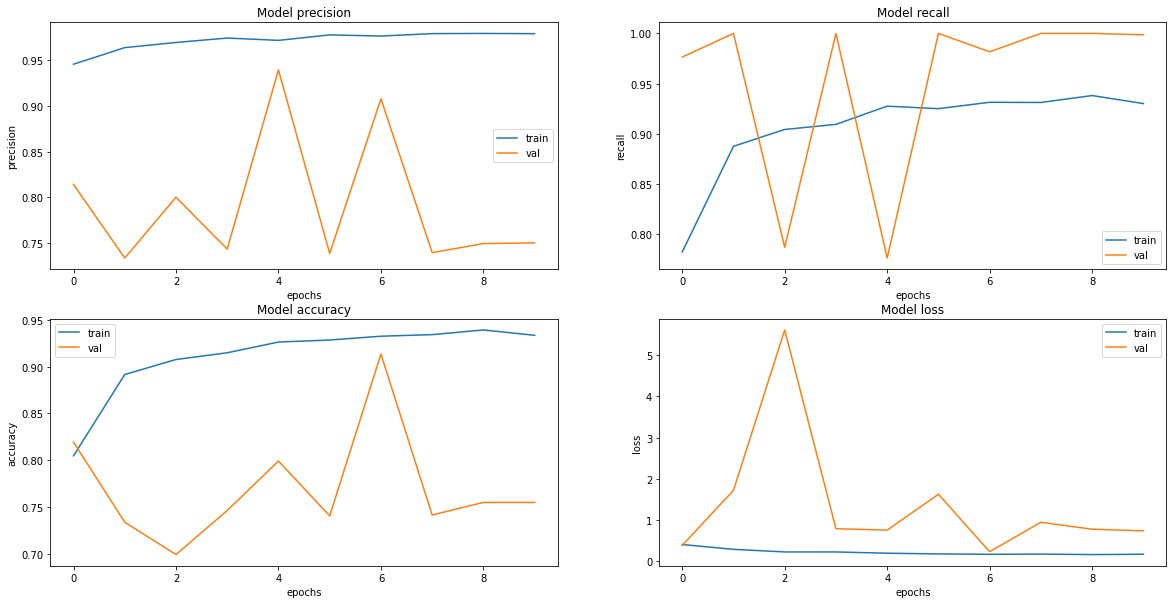

In [154]:
plot_history(history)

또 엄청 튄다. 어떻게 개선할 수 있을까?

In [155]:
test_model(model)

Loss: 2.0003514289855957,
Accuracy: 0.6282051205635071,
Precision: 0.6270096302032471,
Recall: 1.0


성능도 simple cnn에 비해 훨씬 낮다.  
이를 어떻게 해석할 수 있을까?